# COVID cases in TEXAS and infection rate 
## - A Data Science Perspective
## -by Abhijat Goyal

We are more than a month into the COVID-19 pandemic in United States, with New York taking the brunt of the outbreak. Sitting in my home, working on this capstone project for IBM data science specialization, I realize that data is everywhere. I hear Dr Birx repeat many a times about the data driven approach to solving this pandemic. I listen to Dr. Fauci, and he is saying that we need to study the data coming in from states and counties, and that is how the vital medical equipment (such as PPE, ventilators, etc) will be deployed from the federal stockpile based on this micro level data coming in from the county level. They also talk about imperfections in data, wherein 30-40% of testing data is never reported into the CDC. Bottomline, data is everywhere.

In this short capstone project, I will try and present the COVID-19 epidemic in Texas from a data science perspective, and understand how we can use machine learning to predict the future cases. The reason I chose Texas is because I live in Texas. One of the primary underlying factor in predicting how long will this wave last is to study the "infectiousness" of the disease. Scourging the internet for technical details, I found that the primary metric for understanding the spread of this disease and its rate of spread is to understand something called as "R0". Now what is R0? This is called as basic reproduction number. It’s defined as the number of secondary infections produced by a single infection. If R0 is greater than one, the epidemic spreads quickly. If R0 is less than one, there is an inherent damping to the spread, and the infection eventually dies down. The smaller the number is compared to 1, the greater is the rate of die down of the infection in the population. Just to provide the readers with some reference numbers, the flu has an R0 between one and two while measles sits in the high teens. One of the basic flaws with R0 is that it is a static number. We need a better metric, in line with the modern times, in a world where we have data science, wherein we can modify a parameter based on stream of data coming in every few minutes from counties all over the country, and monitor that parameter on a dynamic basis. One such parameter is a modified version of R0, and is called as Rt. Rt is just the time varying, instantaneous version of R0 and provides a more dynamic view of the infectiousness of the disease and helps to predict when the disease will die down.

In their seminal paper in 2008 titled “Real Time Bayesian Estimation of the Epidemic Potential of Emerging Infectious Diseases.” , Bettencourt and Ribeiro proposed a method based on Bayesian statistics to estimate the most likely value of Rt and also return a credible interval for the true value of Rt. Bettencourt & Ribeiro’s original algorithm to estimate Rt is a function of how many new cases appear each day. The relationship between the number of cases yesterday and the number of cases today give us a hint of what Rt might be. However, we can’t rely on any one day too much in trying to guess Rt, as daily case counts are imperfect due to changing testing capacity, lags in data reporting, and random chance. However, using Bayes’ Theorem, we can take the new information we get from each day’s case count to adjust our expectation of what Rt is, getting closer to the true value as more daily data becomes available.

This is Bayes' Theorem as we'll use it:

\begin{equation*}
P(R_t|k)=\frac{P(k|R_t)\cdot P(R_t)}{P(k)}
\end{equation*}

This says that, having seen $k$ new cases, we believe the distribution of $R_t$ is equal to:

1. The likelihood of seeing $k$ new cases given $R_t$ times ...
2. The prior beliefs of the value of $P(R_t)$ without the data ...
3. divided by the probability of seeing this many cases in general.

This is for a single day. To make it iterative: every day that passes, we use yesterday's prior $P(R_{t-1})$ to estimate today's prior $P(R_t)$. We will assume the distribution of $R_t$ to be a Gaussian centered around $R_{t-1}$, so $P(R_t|R_{t-1})=\mathcal{N}(R_{t-1}, \sigma)$, where $\sigma$ is a hyperparameter (see below on how we estimate $\sigma$). So on day one:

$$ P(R_1|k_1) \propto P(R_1)\cdot \mathcal{L}(R_1|k_1)$$
On day two:

$$ P(R_2|k_1,k_2) \propto P(R_2)\cdot \mathcal{L}(R_2|k_2) = \sum_{R_1} {P(R_1|k_1)\cdot P(R_2|R_1)\cdot\mathcal{L}(R_2|k_2) }$$
etc.

One drawback of the algorithm proposed by Bettencourt and Ribeiro is that with time, the value of Rt converges symptotically to 1. However in the real world, the value of Rt can be below 1, and can go to zero, representing a scenario where there is no infection. This was fixed by Kevin Systrom, in his very good work in March of 2020. The modelling approach and data analysis presented in this case study is based on his work.

The first step is to model the 'arrival' process of infections. A popular choice for the distribution of arrivals amongst statisticians is the Poisson Distribution. Accordingly, if we let  λ  represent the average rate of infections per day, then the probability that we are likely to see  k  new cases on a day, is given by

\begin{equation*}
P(k|λ)= λ^k\frac{e^−λ}{k!}
\end{equation*}

Given this setup, we can construct the probability distribution of new cases for a set of  λ's.

# LET'S START WORKING WITH SOME FICTIOUS DATA

In [2]:
#Load packages
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

In [3]:
# Let's do some basic analysis and plot some graphs to gain an understanding of k and lambda
# the first step is to create a column matrix of k, which is infection per day. Let's assume that this can vary from 0 to 70
# just using a "arange" function of numpy to generate the k column vector.


k = np.arange(0, 70)[:, None]


In [6]:
# Let's choose different values of lambda to study the effect of the value of lambda on the distribution of k
lambdas = [10, 15, 20, 25, 30, 35, 40, 50, 60, 70]

# Now let's use scipy to evaluate the poisson's Probability Mass Function
y = sps.poisson.pmf(k, lambdas)

# Let's look at the resulting matrix and see it's shape
print(y.shape)

(70, 10)


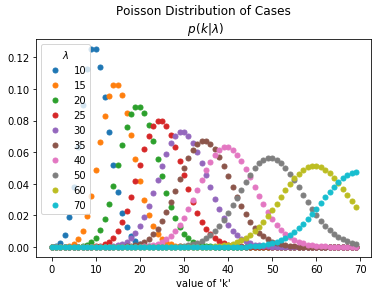

In [7]:
# to gain visual understanding of the k and lambda values and its affect on Poisson's equation

fig, ax = plt.subplots()

ax.set(title='Poisson Distribution of Cases\n $p(k|\lambda)$')

plt.plot(k, y,
         marker='.',
         markersize=10,
         lw=0)

plt.legend(title="$\lambda$", labels=lambdas);
ax.set_xlabel('value of \'k\'');

Please remember that the value of $\lambda$ in the above graph is the number of cases per day. As you can see, there is quite a bit of spread across the value of $\lambda$ and that is the inherent probability that there will not be exactly the same cases every day. There will be a significant noise in the data, as plotted on a daily basis or even hourly basis. For example, imagine we observe $k=30$ new cases, and we want to know how likely each $\lambda$ is:

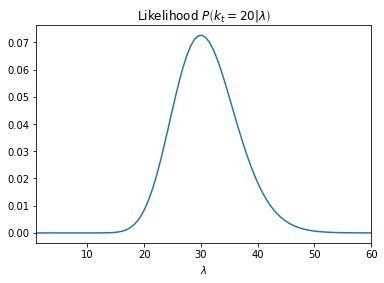

In [9]:
k = 30

lam = np.linspace(1, 60, 90)

likelihood = pd.Series(data=sps.poisson.pmf(k, lam),
                       index=pd.Index(lam, name='$\lambda$'),
                       name='lambda')

likelihood.plot(title=r'Likelihood $P\left(k_t=20|\lambda\right)$');

# Connecting  $\lambda$ and  $R_t$ 

The key insight to making this work is to realize there's a connection between $R_t$ and $\lambda$. The derivation is beyond the scope of this capstone project, but here it is:

$$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$
where $\gamma$ is the reciprocal of the serial interval (about 7 days for COVID19). Since we know every new case count on the previous day, we can now reformulate the likelihood function as a Poisson parameterized by fixing $k$ and varying $R_t$.

$$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$$$P\left(k|R_t\right) = \frac{\lambda^k e^{-\lambda}}{k!}$$

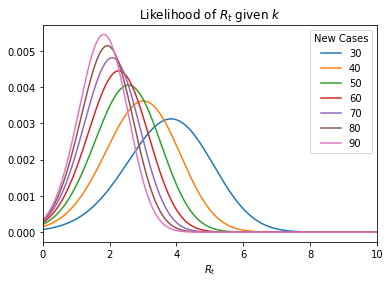

In [13]:
#let's define some arbitary values for k

k = np.array([20, 30, 40, 50, 60, 70, 80, 90])

# now let's define an array for every possible value of Rt. 
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval and is adequately documented and described in the following websites
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316

GAMMA = 1/7

# Now comes the real coding part.
# we need to map Rt into lambda so that it can be substituted into the equation below
# Because we do not have the expectation for first day of the outbreak, we have N-1 lambdas. Inputting the equation described above in the text into our notebook


lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

# now we are set and can evaluate the likelihood on each day. Please note that we have to normalize also for the analysis to make sense

lhood_r_t = sps.poisson.pmf(k[1:], lam)
lhood_r_t /= np.sum(lhood_r_t, axis=0)

# now the mundane task for plotting the data
ax = pd.DataFrame(
    data = lhood_r_t,
    index = r_t_range
).plot(
    title='Likelihood of $R_t$ given $k$',
    xlim=(0,10)
)

ax.legend(labels=k[1:], title='New Cases')
ax.set_xlabel('$R_t$');

To perform the Bayesian update, we need to multiply the likelihood by the prior (which is just the previous day's likelihood without our Gaussian update) to get the posteriors. Let's do that using the cumulative product of each successive day:

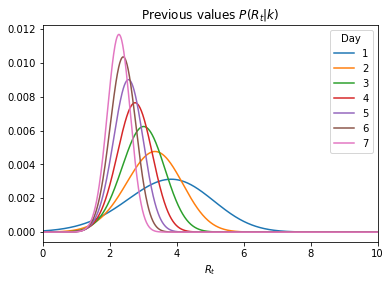

In [14]:
previous_values = lhood_r_t.cumprod(axis=1)
previous_values = previous_values / np.sum(previous_values, axis=0)

columns = pd.Index(range(1, previous_values.shape[1]+1), name='Day')
previous_values = pd.DataFrame(
    data = previous_values,
    index = r_t_range,
    columns = columns)

ax = previous_values.plot(
    title='Previous values $P(R_t|k)$',
    xlim=(0,10)
)
ax.legend(title='Day')
ax.set_xlabel('$R_t$');

In [16]:
present_likely = previous_values.idxmax(axis=0)
present_likely

Day
1    3.84
2    3.36
3    3.01
4    2.76
5    2.56
6    2.40
7    2.28
dtype: float64

In [18]:
#now we need to define the high and low confidence intervals for the data

def highest_density_interval(pmf, p=.9):
   
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

hdi = highest_density_interval(previous_values)
hdi.tail()

,Low_90,High_90
Day,,
3,1.89,4.00
4,1.86,3.58
5,1.79,3.25
6,1.74,3.01
7,1.67,2.80


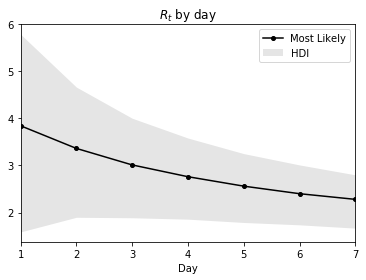

In [19]:
ax = most_likely_values.plot(marker='o',
                             label='Most Likely',
                             title=f'$R_t$ by day',
                             c='k',
                             markersize=4)

ax.fill_between(hdi.index,
                hdi['Low_90'],
                hdi['High_90'],
                color='k',
                alpha=.1,
                lw=0,
                label='HDI')

ax.legend();

# ACTUAL DATA SKIMMING AND ANALYSIS FOR TEXAS

Now that we have understood and implemented the modelling part using a range of data from 20 infections per day to 90 infections per day, let's apply our code to the actual data from Texas which is updated daily

For this, we will be importing data from a website and running our analysis on it.

In [34]:
url = 'https://covidtracking.com/api/v1/states/daily.csv'
states = pd.read_csv(url, usecols=['date', 'state', 'positive'], parse_dates=['date'], index_col=['state', 'date'], squeeze=True).sort_index()

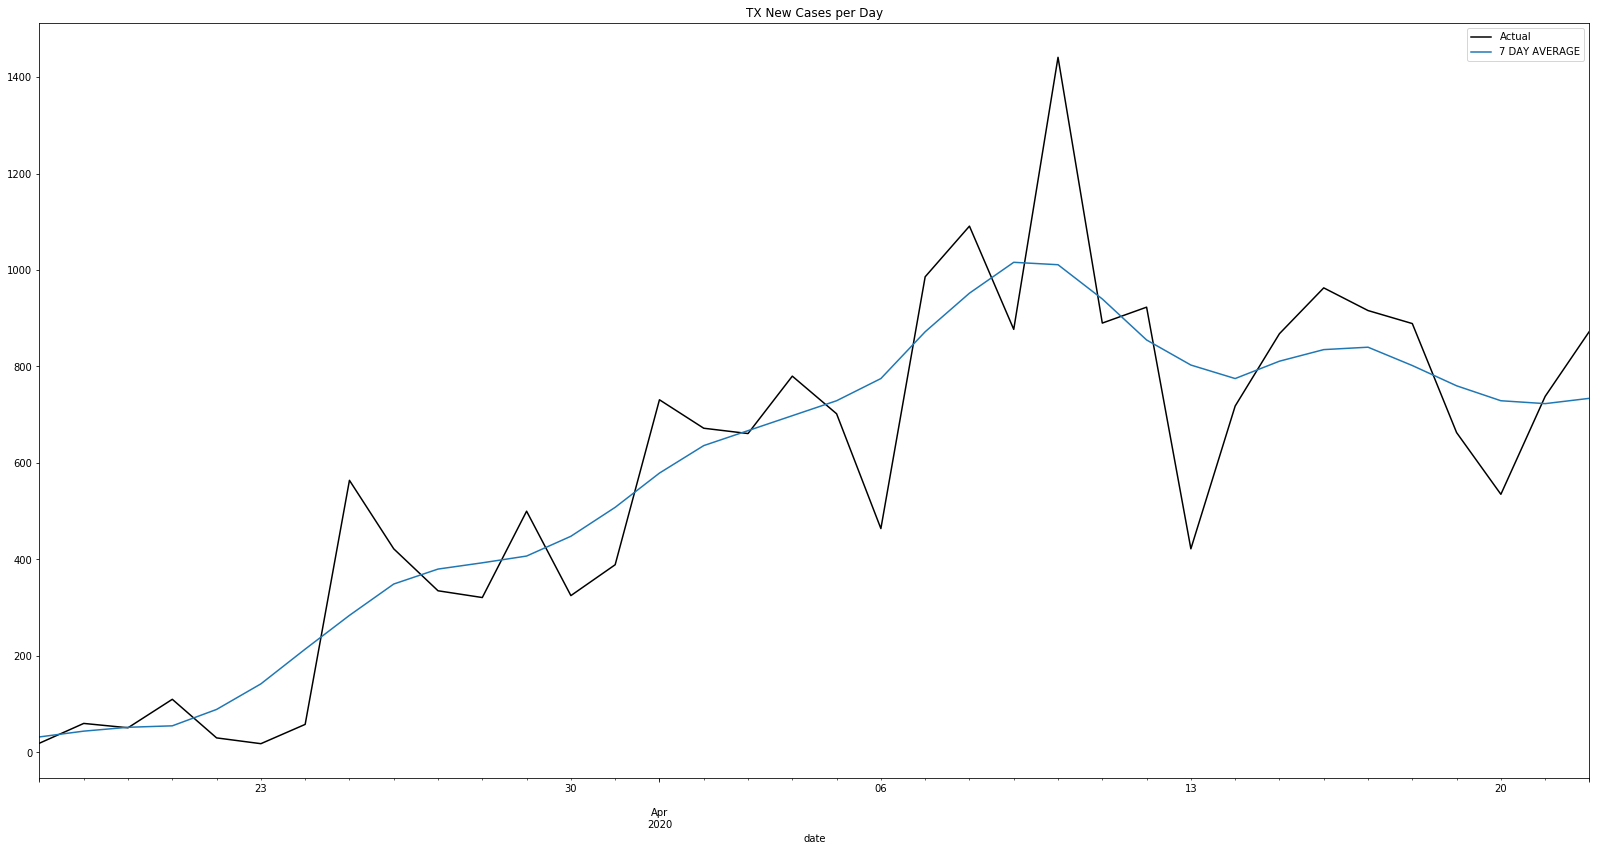

In [86]:
#the above database that was inported has data about all the states. For brevity of a capstone project, we want to concentrate only on the state of TEXAS, where I live

state_name = 'TX'

def lets_plot_it(cases, cutoff=25):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7, win_type='gaussian', min_periods=1, center=True).mean(std=2).round()
    
    idx_start = np.searchsorted(smoothed, cutoff)
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

cases = states.xs(state_name).rename(f"{state_name} cases")

original, smoothed = lets_plot_it(cases)

original.plot(title=f"{state_name} New Cases per Day", c='k', linestyle='-', label='Actual', legend=True, figsize=(2000/72, 1000/72))

ax = smoothed.plot(label='7 DAY AVERAGE', legend=True)

#below is the plot of daily new cases in texas and also the smoothened fit to the data

In [88]:
#this is the part where we calculate the previous values, just like we did it in the code above for the general made up case


def get_previous_values(sr, sigma=0.15):

    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))
    likelihoods = pd.DataFrame(data = sps.poisson.pmf(sr[1:].values, lam), index = r_t_range, columns = sr.index[1:])
    process_matrix = sps.norm(loc=r_t_range, scale=sigma).pdf(r_t_range[:, None]) 

    process_matrix /= process_matrix.sum(axis=0)
    
    previous0 = sps.gamma(a=4).pdf(r_t_range)
    previous0 /= previous0.sum()

    posteriors = pd.DataFrame(index=r_t_range, columns=sr.index, data={sr.index[0]: previous0})
    log_likelihood = 0.0

    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        current_prior = process_matrix @ posteriors[previous_day]
        numerator = likelihoods[current_day] * current_prior
        denominator = np.sum(numerator)
        posteriors[current_day] = numerator/denominator
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

# Note that we're fixing sigma to a value just for the example
posteriors, log_likelihood = get_previous_values(smoothed, sigma=.25)


In [89]:
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

result = pd.concat([most_likely, hdis], axis=1)

result

#this is the result in a tabular format of the infectivity that we get for each day spanning past 45 days or so

,ML,Low_90,High_90
date,,,
2020-03-18,3.00,0.86,6.84
2020-03-19,3.18,1.70,4.62
2020-03-20,2.68,1.54,3.69
2020-03-21,2.20,1.24,3.05
2020-03-22,3.01,2.17,3.76
2020-03-23,3.57,2.84,4.18
2020-03-24,3.72,3.12,4.24
2020-03-25,3.34,2.81,3.78
2020-03-26,2.87,2.39,3.27


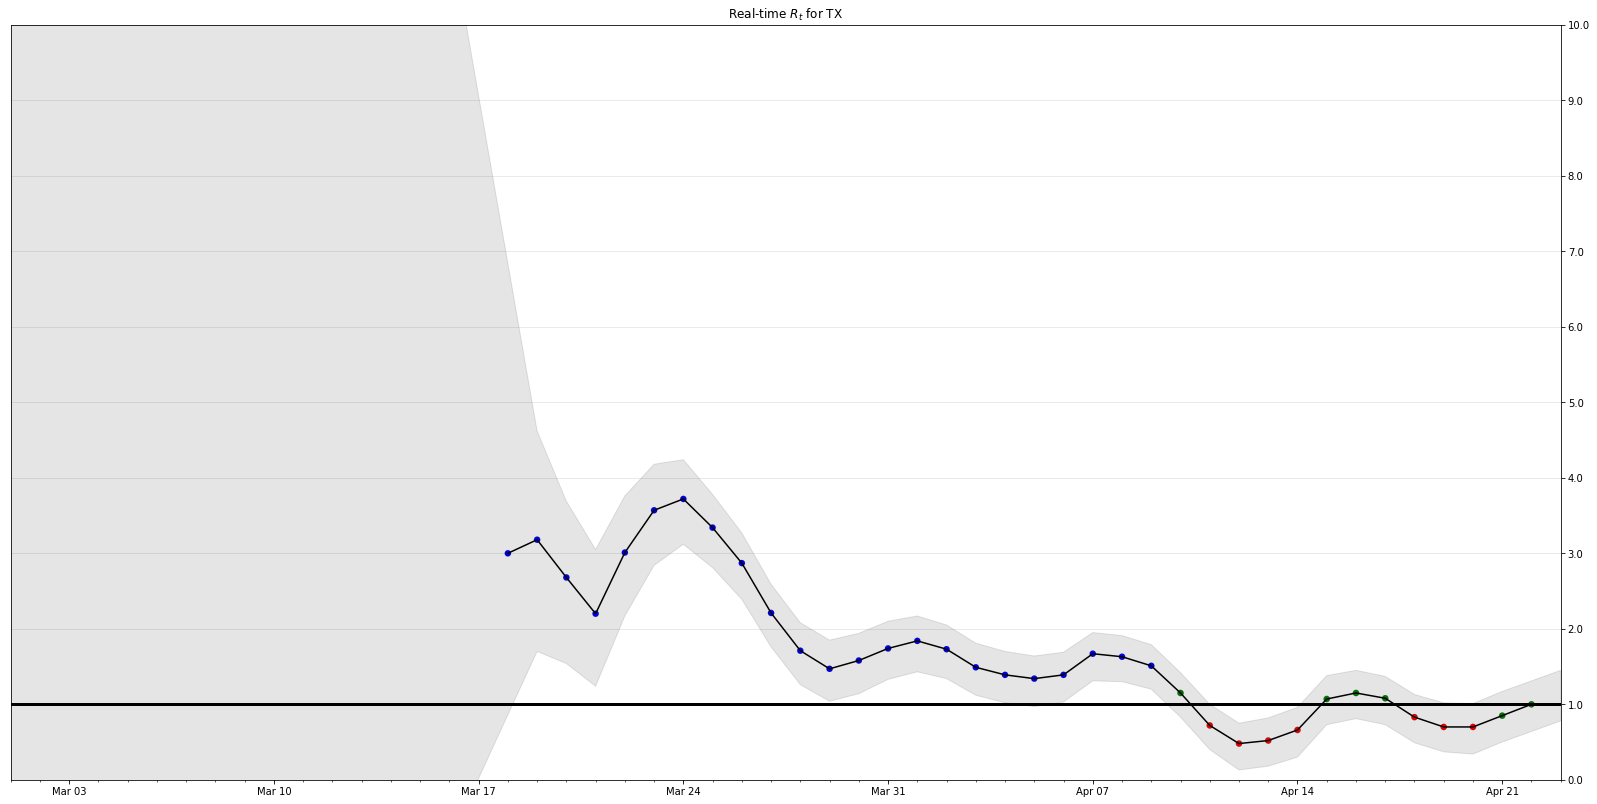

In [91]:
#above we have shown the data. Now we just have to plot it. That is what the code below does.


def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(['r', 'g', 'b'])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k')
    ax.scatter(index, values, s=40, lw=0.1, c=cmap(color_mapped(values)), edgecolors='k')
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index), result['Low_90'].values, bounds_error=False, fill_value='extrapolate')
    highfn = interp1d(date2num(index), result['High_90'].values, bounds_error=False, fill_value='extrapolate')
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'), end=index[-1]+pd.Timedelta(days=1))
    ax.fill_between(extended, lowfn(date2num(extended)), highfn(date2num(extended)), color='k', alpha = 0.1)
    ax.axhline(1.0, c='k', lw=3, label='$R_t=1.0$');
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.grid(which='major', axis='y', c='k', alpha=.1)
    ax.set_ylim(0.0, 10.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
  

    
fig, ax = plt.subplots(figsize=(2000/72,1000/72))

plot_rt(result, ax, state_name)
ax.set_title(f'Real-time $R_t$ for {state_name}')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

As we can see from the above graph, the dynamic infection rate fell below one sometimes around April 10. It then bounced back and now it is hovering around 0.5. Since any value of less than one results in the infection eventually dying down with time, this is great news for the state of Texas.